========== LightGBM_shap 44 79 78 ==========
ADF Statistic: -16.157231
p-value: 0.000000
Critical Values:
The time series is stationary.
0.8 [0.791, 0.807](K=44)
0.94968045737666 ± 0.0303672392923316 (K=79)
0.9675400144196106(K=78)


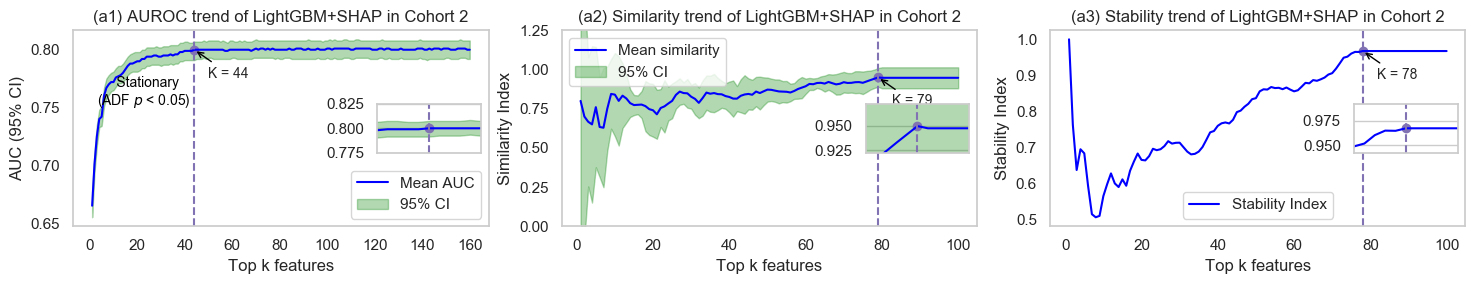

========== XGBoost_shap 44 78 78 ==========
ADF Statistic: -3.457485
p-value: 0.009149
Critical Values:
The time series is stationary.
0.798 [0.79, 0.805](K=44)
0.9619047619047618 ± 0.0294400587158593 (K=78)
0.9695671117443272(K=78)


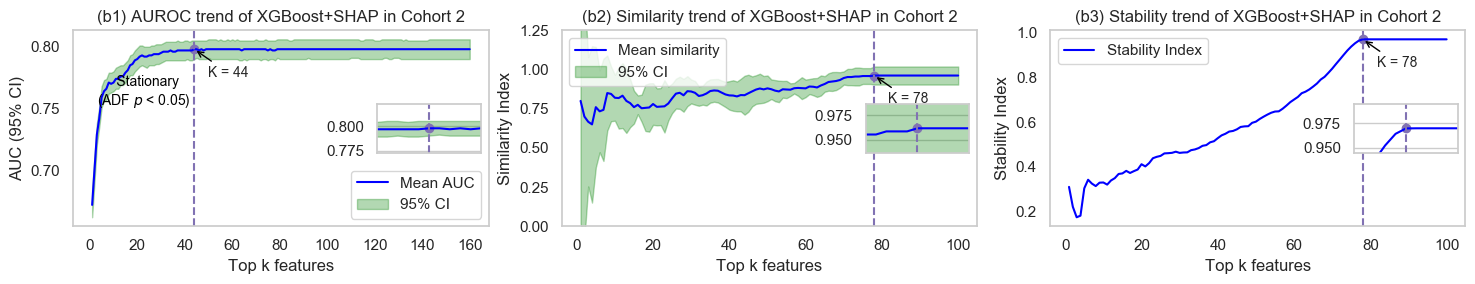

========== Catboost_shap 45 83 78 ==========
ADF Statistic: -4.458902
p-value: 0.000233
Critical Values:
The time series is stationary.
0.79 [0.781, 0.798](K=45)
0.9555555555555556 ± 0.0185924450340905 (K=83)
0.970414277087162(K=78)


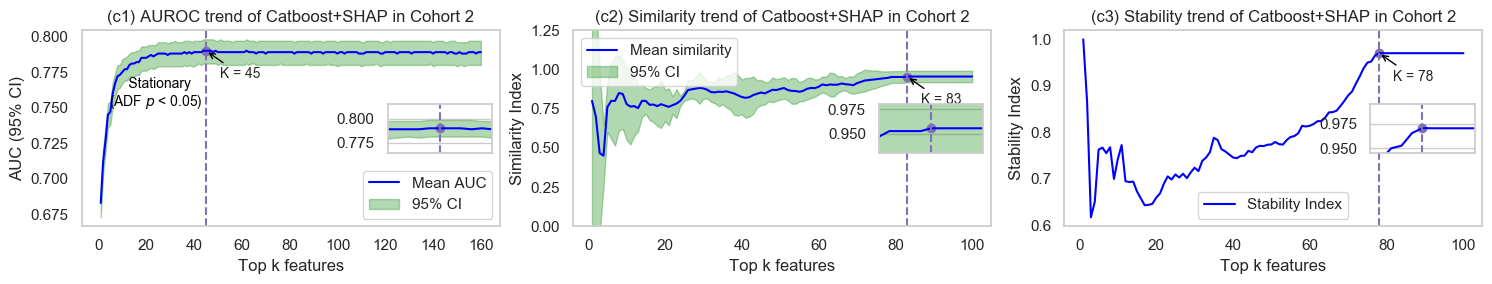

========== LightGBM 64 79 81 ==========
ADF Statistic: -17.081880
p-value: 0.000000
Critical Values:
The time series is stationary.
0.8 [0.792, 0.807](K=64)
0.963936507936508 ± 0.0154138018011857 (K=79)
0.9733053555230612(K=81)


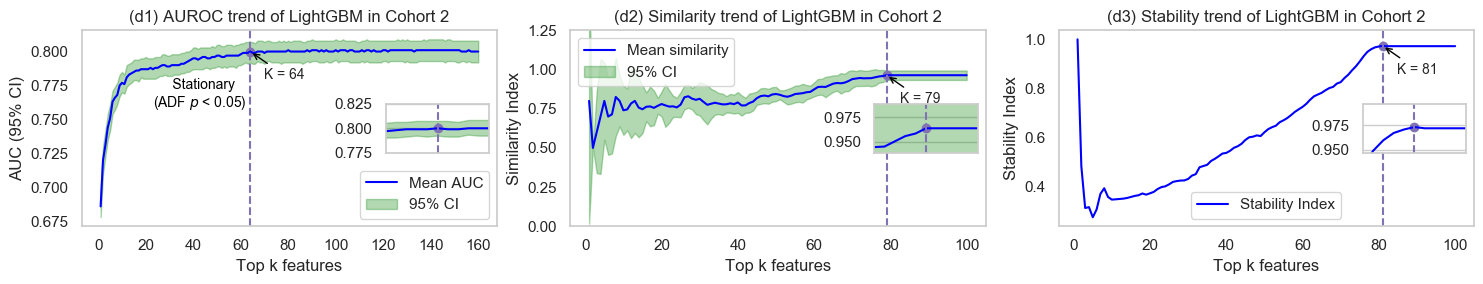

========== XGBoost 43 83 66 ==========
ADF Statistic: -9.163941
p-value: 0.000000
Critical Values:
The time series is stationary.
0.798 [0.79, 0.805](K=43)
0.93741341991342 ± 0.039029455321769 (K=83)
0.9757497903331234(K=66)


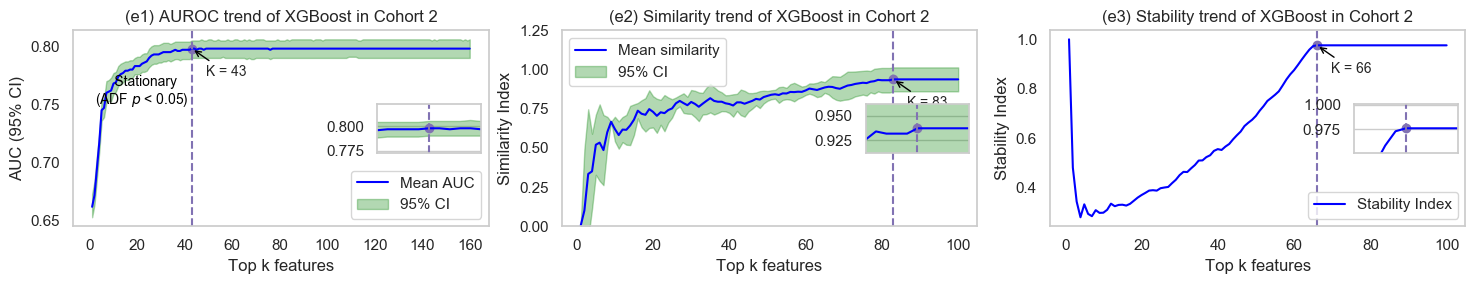

========== Catboost 40 83 71 ==========
ADF Statistic: -4.828153
p-value: 0.000048
Critical Values:
The time series is stationary.
0.79 [0.781, 0.798](K=40)
0.9450851370851372 ± 0.0243371912572141 (K=83)
0.9715785006211988(K=71)


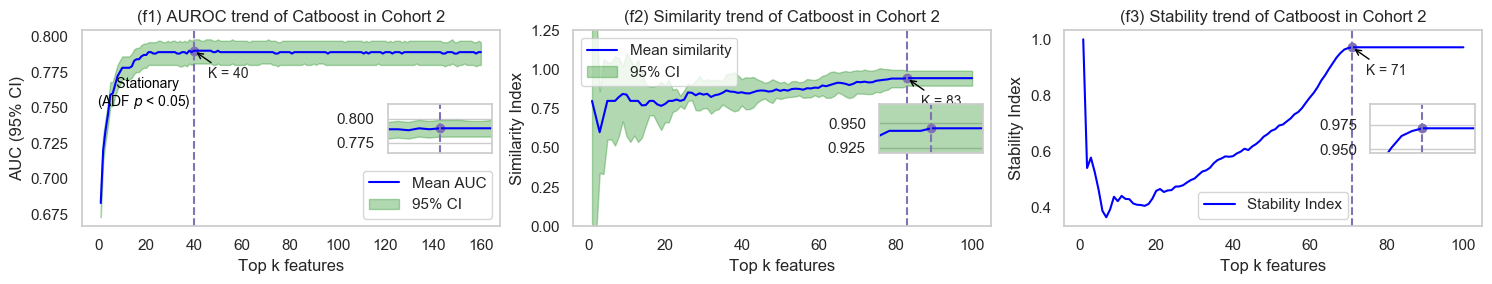

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import os
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2' 
save_path = cd + '/decision_topk/'

if os.path.exists(save_path)==False:
    os.makedirs(save_path)

methods = ['LightGBM_shap', 'XGBoost_shap', 'Catboost_shap', 'LightGBM', 'XGBoost', 'Catboost']
fig_index = ['a', 'b', 'c', 'd', 'e', 'f']
methods_name = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP', 'LightGBM', 'XGBoost', 'Catboost']

ks = [44,44,45,64,43,40]
ks_similarity = [79,78,83,79,83,83]
ks_stability=[78,78,78,81,66,71]

for index, method in enumerate(methods):
    k, k_similarity, k_stability = ks[index], ks_similarity[index], ks_stability[index]
    print('='*10, method, k, k_similarity, k_stability, '='*10)

    # Load data for each method
    if 'shap' in method:
        base_method = method[:-5]
        imp_suffix, trend_suffix = '_SHAP_imp.csv', '_SHAP_auc_95CI_trend.csv'
        sim_suffix, stab_suffix = '_shap.csv', '_shap.csv'
    else:
        base_method = method
        imp_suffix, trend_suffix = '_imp.csv', '_auc_95CI_trend.csv'
        sim_suffix, stab_suffix = '.csv', '_weight.csv'

    # Read AUC, Similarity, and Stability data
    df_auc = pd.read_csv(f"{cd}/get_topK_auc_trend/{base_method}{trend_suffix}")
    df_similarity = pd.read_csv(f"{cd}/plot_similarity_figures/step3_compute_similarity_trend/avg_std_topK_similarity_{base_method}{sim_suffix}", index_col=0)
    df_stability = pd.DataFrame({'stability': pd.read_csv(f"{cd}/plot_stability_figures/step3-compute stability index/topK_stability_{base_method}{stab_suffix}").squeeze()[1:]})

    result = adfuller(df_auc[:k+1]['meanAUC'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    # for key, value in result[4].items():
    #     print('\t%s: %.3f' % (key, value))
    if result[1] < 0.01:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")        
    
    k_auc_row = df_auc.loc[df_auc['topK'] == k]
    k_auc = k_auc_row['meanAUC'].values[0]
    dCI = k_auc_row['dCI'].values[0]
    uCI = k_auc_row['uCI'].values[0]
    print(f"{k_auc} [{dCI}, {uCI}](K={k})")

    k_simi = df_similarity.iloc[k_similarity-1]
    avg_simi = k_simi['avg_similarity']
    std_simi = k_simi['std_similarity']
    print(f"{avg_simi} ± {std_simi} (K={k_similarity})")

    ks_stab = df_stability['stability'][k_stability-1]
    print(f'{ks_stab}(K={k_stability})')

    fig = plt.figure(figsize=(15, 3))
    gs = GridSpec(1, 3, figure=fig)

    # AUC Trend
    ax2 = fig.add_subplot(gs[0, 0])
    ax2.plot(df_auc['topK'], df_auc['meanAUC'], color='blue', label='Mean AUC')
    ax2.fill_between(df_auc['topK'], df_auc['dCI'], df_auc['uCI'], color='green', alpha=0.3, label='95% CI')
    ax2.axvline(x=k, ls="--", c="m")
    ax2.scatter(k, k_auc, c='m')
    ax2.annotate(f'K = {k}', xy=(k, k_auc), xycoords='data', xytext=(+10, -20), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', color='black'))
    ax2.annotate('     Stationary\n(ADF $p$ < 0.05)', xy=(k, k_auc), xycoords='data', xytext=(-70, -40), textcoords='offset points', fontsize=10, color='black')
    ax2.set_xlabel('Top k features')
    ax2.set_ylabel('AUC (95% CI)')
    ax2.set_title(f'({fig_index[index]}1) AUROC trend of {methods_name[index]} in Cohort 2')
    ax2.grid(False)
    ax2.legend()
    
    # Adding inset for AUC
    axins2 = inset_axes(ax2, width="25%", height="25%", loc='center right')
    axins2.plot(df_auc['topK'], df_auc['meanAUC'], color='blue')
    axins2.fill_between(df_auc['topK'], df_auc['dCI'], df_auc['uCI'], color='green', alpha=0.3)
    axins2.set_xlim(k-5, k+5)
    axins2.set_ylim(k_auc-0.025, k_auc+0.025)
    axins2.axvline(x=k, ls="--", c="m")
    axins2.scatter(k, k_auc, c='m')
    axins2.set_xticks([])

    # Similarity Trend
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.plot(range(1, len(df_similarity)+1), df_similarity['avg_similarity'], color='blue', label='Mean similarity')
    ax3.fill_between(range(1, len(df_similarity)+1), df_similarity['avg_similarity'] - 1.96 * df_similarity['std_similarity'], df_similarity['avg_similarity'] + 1.96 * df_similarity['std_similarity'], color='green', alpha=0.3, label='95% CI')
    ax3.axvline(x=k_similarity, ls="--", c="m")
    ax3.scatter(k_similarity, avg_simi, c='m')
    ax3.annotate(f'K = {k_similarity}', xy=(k_similarity, avg_simi), xycoords='data', xytext=(+10, -20), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', color='black'))
    ax3.set_xlabel('Top k features')
    ax3.set_ylabel('Similarity Index')
    ax3.set_title(f'({fig_index[index]}2) Similarity trend of {methods_name[index]} in Cohort 2')
    ax3.set_ylim(0,1.25)
    ax3.grid(False)
    ax3.legend()
    
    # Adding inset for Similarity Trend
    axins3 = inset_axes(ax3, width="25%", height="25%", loc='center right')
    axins3.plot(range(1, len(df_similarity)+1), df_similarity['avg_similarity'], color='blue')
    axins3.fill_between(range(1, len(df_similarity)+1), df_similarity['avg_similarity'] - 1.96 * df_similarity['std_similarity'], df_similarity['avg_similarity'] + 1.96 * df_similarity['std_similarity'], color='green', alpha=0.3)
    axins3.set_xlim(k_similarity-5, k_similarity+5)
    axins3.set_ylim(df_similarity['avg_similarity'][k_similarity]-0.025, df_similarity['avg_similarity'][k_similarity]+0.025)
    axins3.axvline(x=k_similarity, ls="--", c="m")
    axins3.scatter(k_similarity, avg_simi, c='m')
    axins3.set_xticks([])
    
    # Stability Trend
    ax4 = fig.add_subplot(gs[0, 2])
    ax4.plot(range(1, len(df_stability)+1), df_stability['stability'], color='blue', label='Stability Index')
    ax4.axvline(x=k_stability, ls="--", c="m")
    ax4.scatter(k_stability, ks_stab, c='m')
    ax4.annotate(f'K = {k_stability}', xy=(k_stability, ks_stab), xycoords='data', xytext=(+10, -20), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', color='black'))
    ax4.set_xlabel('Top k features')
    ax4.set_ylabel('Stability Index')
    ax4.set_title(f'({fig_index[index]}3) Stability trend of {methods_name[index]} in Cohort 2')
    ax4.grid(False)
    ax4.legend()
    
    # Adding inset for Stability Trend
    axins4 = inset_axes(ax4, width="25%", height="25%", loc='center right')
    axins4.plot(range(1, len(df_stability)+1), df_stability['stability'], color='blue')
    axins4.set_xlim(k_stability-5, k_stability+5)
    axins4.set_ylim(df_stability['stability'][k_stability]-0.025, df_stability['stability'][k_stability]+0.025)
    axins4.axvline(x=k_stability, ls="--", c="m")
    axins4.scatter(k_stability, ks_stab, c='m')
    axins4.set_xticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{method}.png'), dpi=300, bbox_inches='tight')

    plt.show()

### Determination of **Top K** based on accuracy, similarity, and stability

| Model          | AUROC [95% CI] (Top K)      | Similarity Index (Top K)                         | Stability Index (Top K)   | Max Top K |
|----------------|-----------------------------|-------------------------------------------------|---------------------------|-----------|
| LightGBM+SHAP  | 0.8 [0.791, 0.807] (K=44)   | 0.950 ± 0.030 (K=79)                            | 0.968 (K=78)              | 79        |
| XGBoost+SHAP   | 0.798 [0.79, 0.805] (K=44)  | 0.962 ± 0.029 (K=78)                            | 0.970 (K=78)              | 78        |
| Catboost+SHAP  | 0.79 [0.781, 0.798] (K=45)  | 0.956 ± 0.019 (K=83)                            | 0.970 (K=78)              | 83        |
| LightGBM       | 0.8 [0.792, 0.807] (K=64)   | 0.964 ± 0.015 (K=79)                            | 0.973 (K=81)              | 81        |
| XGBoost        | 0.798 [0.79, 0.805] (K=43)  | 0.937 ± 0.039 (K=83)                            | 0.976 (K=66)              | 83        |
| Catboost       | 0.79 [0.781, 0.798] (K=40)  | 0.945 ± 0.024 (K=83)                            | 0.972 (K=71)              | 83        |

#### Table Note:
- AUROC [95% CI] (Top K), Similarity Index (Top K), and Stability Index (Top K) report the top K features determined by the elbow method applied to their respective curves. "Max Top K" is the maximum Top K value across these indices for each model, serving as the final top K value for feature selection.